# Chapter 10: Portfolio Analysis and Risk Management

Portfolio analysis is the cornerstone of effective investment decision-making. By constructing a diversified portfolio, investors can mitigate risk while optimizing returns. This chapter delves into the core concepts and methodologies used to analyze and manage investment portfolios.

We will access real-world financial data using Tiingo's API, enabling us to conduct practical analyses. Our focus will be on calculating key metrics such as beta, estimating expected returns using the Capital Asset Pricing Model (CAPM), and evaluating portfolio performance.

Furthermore, we will explore advanced techniques like covariance matrices to assess portfolio diversification and introduce multi-factor models, such as the Fama-French three-factor model, to refine our understanding of risk and return.

## 10.1 Setting Up the Environment

In [1]:
import os
from tiingo import TiingoClient
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import datetime

# Configure Tiingo with proper error handling
try:
    config = {
        'session': True,
        'api_key': os.getenv('TIINGO_API_KEY', 'YOUR API KEY')
    }
    client = TiingoClient(config)
except Exception as e:
    print(f"Error initializing Tiingo client: {e}")
    raise

# Function to safely get Tiingo data
def get_tiingo_data(ticker, start_date, end_date):
    """Robust data fetcher with DataFrame conversion and validation"""
    try:
        raw_data = client.get_dataframe(ticker,
                                     startDate=start_date,
                                     endDate=end_date,
                                     frequency='daily')
        df = pd.DataFrame(raw_data)
        
        # Validate we have required columns
        required_cols = ['adjClose', 'close']
        for col in required_cols:
            if col not in df.columns:
                raise ValueError(f"Missing required column: {col}")
                
        # Convert to numeric
        price_cols = ['open', 'high', 'low', 'close', 'adjClose']
        for col in price_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        return df
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        raise

## 10.2 Fetching Historical Prices

In [2]:
# Define assets
stock_ticker = "AAPL"
market_ticker = "SPY"
portfolio_tickers = ["AAPL", "MSFT", "GOOGL"]  

# Fetch data 
try:
    stock_prices = get_tiingo_data(stock_ticker, '2018-01-01', '2023-01-01')
    market_prices = get_tiingo_data(market_ticker, '2018-01-01', '2023-01-01')
    
    
    print("\nAAPL Prices (head):")
    print(stock_prices[['adjClose', 'close']].head())
    print("\nSPY Prices (head):")
    print(market_prices[['adjClose', 'close']].head())
    
    # Explanation of adjusted close
    print("\n[Explanation] adjClose vs close:")
    print("adjClose: Price adjusted for all corporate actions (splits, dividends)")
    print("close: Raw closing price without adjustments")
    print("We'll use adjClose for accurate return calculations")
    
except Exception as e:
    print(f"Data loading failed: {e}")
    raise

Fetching and validating market data...

AAPL Prices (head):
                            adjClose   close
date                                        
2018-01-02 00:00:00+00:00  40.479208  172.26
2018-01-03 00:00:00+00:00  40.472158  172.23
2018-01-04 00:00:00+00:00  40.660149  173.03
2018-01-05 00:00:00+00:00  41.123078  175.00
2018-01-08 00:00:00+00:00  40.970335  174.35

SPY Prices (head):
                             adjClose   close
date                                         
2018-01-02 00:00:00+00:00  239.101332  268.77
2018-01-03 00:00:00+00:00  240.613674  270.47
2018-01-04 00:00:00+00:00  241.627833  271.61
2018-01-05 00:00:00+00:00  243.238033  273.42
2018-01-08 00:00:00+00:00  243.682840  273.92

[Explanation] adjClose vs close:
adjClose: Price adjusted for all corporate actions (splits, dividends)
close: Raw closing price without adjustments
We'll use adjClose for accurate return calculations


## 10.3 Calculating Log Returns


Calculating log returns...


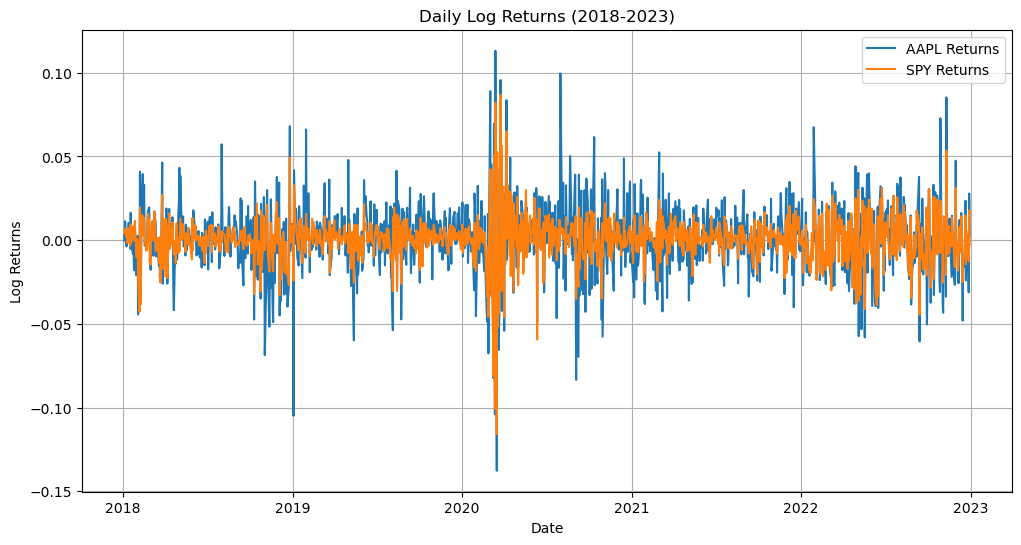


Return Statistics:
AAPL mean return: 0.000918
SPY mean return: 0.000349

[Note] These log returns will be used for beta calculation and portfolio analysis


In [3]:
def safe_log_returns(df, col='adjClose'):
    """Robust log return calculation with validation"""
    if col not in df.columns:
        raise ValueError(f"Column {col} not found")
    prices = pd.to_numeric(df[col], errors='coerce')
    return np.log(prices / prices.shift(1)).dropna()


stock_prices['log_return'] = safe_log_returns(stock_prices)
market_prices['log_return'] = safe_log_returns(market_prices)


stock_returns = stock_prices['log_return'].dropna()
market_returns = market_prices['log_return'].dropna()

# Enhanced visualization
plt.figure(figsize=(12,6))
plt.plot(stock_returns, label=f'{stock_ticker} Returns')
plt.plot(market_returns, label=f'{market_ticker} Returns')
plt.title('Daily Log Returns (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True)
plt.show()


print("\nReturn Statistics:")
print(f"{stock_ticker} mean return: {stock_returns.mean():.6f}")
print(f"{market_ticker} mean return: {market_returns.mean():.6f}")
print("\n[Note] These log returns will be used for beta calculation and portfolio analysis")

## 10.4 Estimating Beta ($\beta$)



Calculating beta using linear regression...

Regression Results:
                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     2294.
Date:                Sun, 06 Apr 2025   Prob (F-statistic):          1.16e-285
Time:                        12:22:58   Log-Likelihood:                 3722.6
No. Observations:                1258   AIC:                            -7441.
Df Residuals:                    1256   BIC:                            -7431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

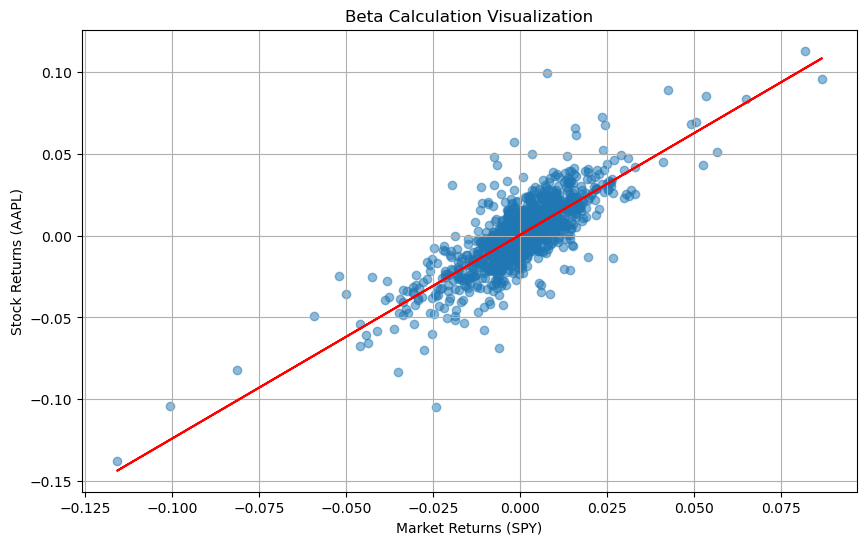

In [4]:
# Prepare data as you specified
market_returns_with_constant = sm.add_constant(market_returns)

# Your OLS regression
model = sm.OLS(stock_returns, market_returns_with_constant).fit()
beta = model.params[1]  

# Enhanced output
print("\nRegression Results:")
print(model.summary())  # Shows full regression output


print(f"\nBeta (β) for {stock_ticker}: {beta:.4f}")
print("Interpretation:")
if beta > 1:
    print(f"- {stock_ticker} is more volatile than the market (β > 1)")
elif beta < 1:
    print(f"- {stock_ticker} is less volatile than the market (β < 1)")
else:
    print(f"- {stock_ticker} moves with the market (β ≈ 1)")

# Visual proof
plt.figure(figsize=(10,6))
plt.scatter(market_returns, stock_returns, alpha=0.5)
plt.plot(market_returns, model.predict(), color='red')
plt.xlabel('Market Returns (SPY)')
plt.ylabel('Stock Returns (AAPL)')
plt.title('Beta Calculation Visualization')
plt.grid(True)
plt.show()

## 10.5 Calculating Expected Return Using CAPM

The Capital Asset Pricing Model (CAPM) is used to calculate the expected return of a stock based on its beta, the risk-free rate, and the expected market return.


Calculating expected return using CAPM...

CAPM Expected Annual Return for AAPL:
Risk-free rate: 2.00%
Market return: 8.79%
Beta: 1.24
Expected return: 10.45%

Actual annualized return: 23.13%
Difference: -12.68%


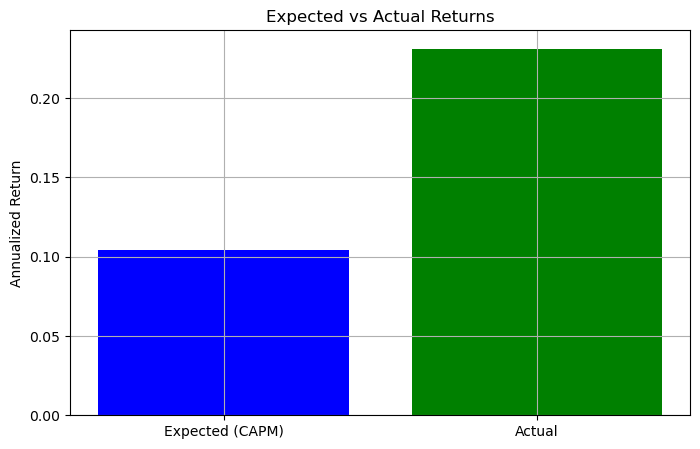

In [5]:
risk_free_rate = 0.02  # 
market_return = market_returns.mean() * 252  # Annualized

expected_return = risk_free_rate + beta * (market_return - risk_free_rate)

# Enhanced output
print(f"\nCAPM Expected Annual Return for {stock_ticker}:")
print(f"Risk-free rate: {risk_free_rate:.2%}")
print(f"Market return: {market_return:.2%}")
print(f"Beta: {beta:.2f}")
print(f"Expected return: {expected_return:.2%}")

# Comparison to actual returns
actual_annual_return = stock_returns.mean() * 252
print(f"\nActual annualized return: {actual_annual_return:.2%}")
print(f"Difference: {expected_return - actual_annual_return:.2%}")

# Visual comparison
plt.figure(figsize=(8,5))
plt.bar(['Expected (CAPM)', 'Actual'], 
        [expected_return, actual_annual_return],
        color=['blue', 'green'])
plt.title('Expected vs Actual Returns')
plt.ylabel('Annualized Return')
plt.grid(True)
plt.show()

## 10.6 Portfolio Analysis


Analyzing portfolio...

Expected Returns:
AAPL: 0.1045 (10.45%)
MSFT: 0.1032 (10.32%)
GOOGL: 0.0988 (9.88%)

Portfolio Beta (weighted): 1.2141
Portfolio Annualized Return: 0.1877 (18.77%)


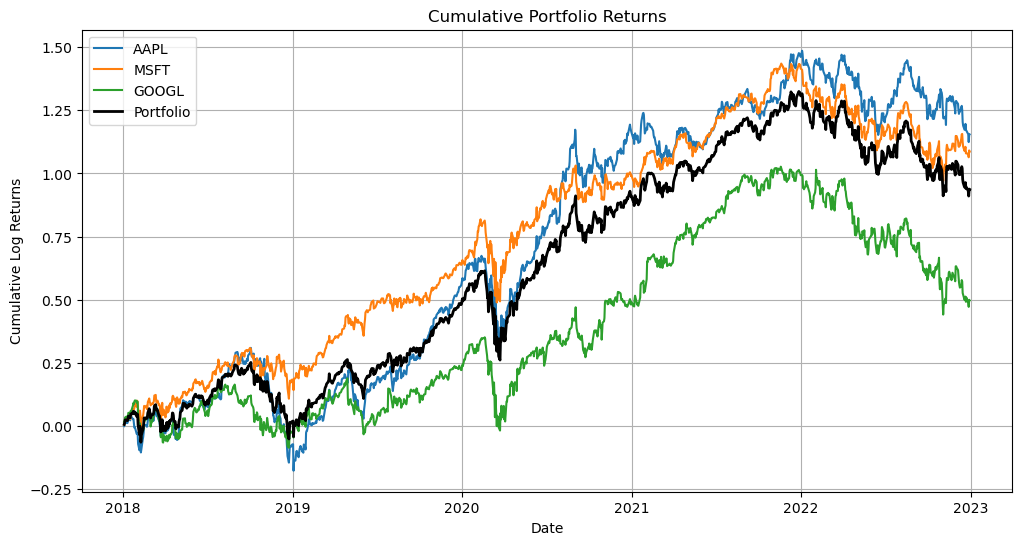

In [6]:
# Fetch all portfolio data
portfolio = {}
for ticker in portfolio_tickers:
    portfolio[ticker] = get_tiingo_data(ticker, '2018-01-01', '2023-01-01')
    portfolio[ticker]['log_return'] = safe_log_returns(portfolio[ticker])

# Calculate betas
betas = {}
for ticker in portfolio_tickers:
    returns = portfolio[ticker]['log_return'].dropna()
    model = sm.OLS(returns, sm.add_constant(market_returns)).fit()
    betas[ticker] = model.params[1]

# Calculate expected returns
expected_returns = {}
for ticker in portfolio_tickers:
    expected_returns[ticker] = risk_free_rate + betas[ticker] * (market_return - risk_free_rate)

print("\nExpected Returns:")
for ticker, ret in expected_returns.items():
    print(f"{ticker}: {ret:.4f} ({ret:.2%})")

# Portfolio beta calculation
weights = np.array([0.4, 0.3, 0.3])  # Example weights
portfolio_beta = sum(weights * np.array([betas[t] for t in portfolio_tickers]))
print(f"\nPortfolio Beta (weighted): {portfolio_beta:.4f}")

# Portfolio returns analysis
portfolio_returns = sum(weights[i] * portfolio[ticker]['log_return'] 
                       for i, ticker in enumerate(portfolio_tickers))
portfolio_annual_return = portfolio_returns.mean() * 252
print(f"Portfolio Annualized Return: {portfolio_annual_return:.4f} ({portfolio_annual_return:.2%})")

# Visualize portfolio components
plt.figure(figsize=(12,6))
for ticker in portfolio_tickers:
    plt.plot(portfolio[ticker]['log_return'].cumsum(), label=ticker)
plt.plot(portfolio_returns.cumsum(), label='Portfolio', linewidth=2, color='black')
plt.title('Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Log Returns')
plt.legend()
plt.grid(True)
plt.show()

## 10.7 Multi-Factor Models


Fetching Fama-French 3-Factor data...


C:\Users\david\AppData\Local\Temp\ipykernel_14460\1681442702.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = web.DataReader('F-F_Research_Data_Factors_daily',



Fama-French Factors (head):
                           Mkt-RF     SMB     HML       RF
Date                                                      
2018-01-02 00:00:00+00:00  0.0085  0.0035 -0.0022  0.00006
2018-01-03 00:00:00+00:00  0.0059 -0.0039 -0.0018  0.00006
2018-01-04 00:00:00+00:00  0.0042 -0.0026  0.0024  0.00006
2018-01-05 00:00:00+00:00  0.0066 -0.0036 -0.0026  0.00006
2018-01-08 00:00:00+00:00  0.0019 -0.0015  0.0004  0.00006

Factor Descriptions:
- Mkt-RF: Market excess return (market return minus risk-free rate)
- SMB: Small Minus Big (size factor - small cap outperformance)
- HML: High Minus Low (value factor - value stock outperformance)
- RF: Risk-free rate

AAPL Factor Loadings:
Mkt-RF: 1.2104 (t=50.75)
SMB: -0.3473 (t=-7.32)
HML: -0.3916 (t=-13.13)

Practical Interpretation:
- Negative SMB loading indicates large-cap characteristics
- Negative HML loading indicates growth stock characteristics

MSFT Factor Loadings:
Mkt-RF: 1.2012 (t=69.72)
SMB: -0.4573 (t=-13.34)
HM

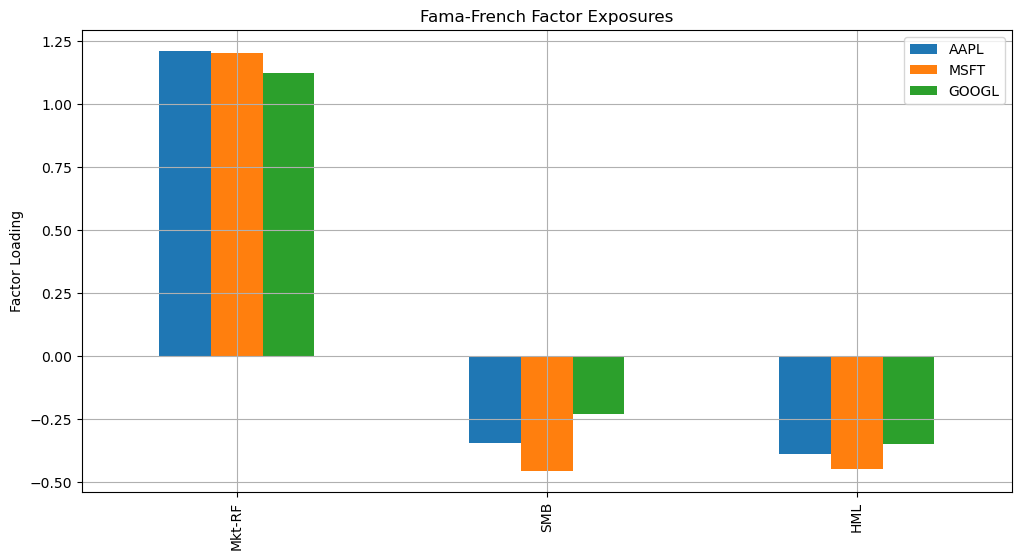

In [7]:
def get_fama_french_factors(start_date, end_date):
    """
    Safely fetch Fama-French factors with proper date handling
    Returns:
        DataFrame with factors and properly formatted DateTimeIndex
    """
    try:
        # Fetch data
        ff_data = web.DataReader('F-F_Research_Data_Factors_daily', 
                               'famafrench',
                               start=start_date, 
                               end=end_date)
        
        # The factors are in the first element of the returned tuple
        factors = ff_data[0].copy()
        
        # Convert returns to decimals (from percentages)
        factors[['Mkt-RF', 'SMB', 'HML', 'RF']] /= 100
        
        # Properly handle the index conversion
        factors.index = pd.to_datetime(factors.index, format='%Y%m%d')
        factors.index = factors.index.tz_localize('UTC')
        
        return factors
    
    except Exception as e:
        print(f"Error fetching Fama-French factors: {e}")
        raise


print("\nFetching Fama-French 3-Factor data...")
try:
    ff_factors = get_fama_french_factors(datetime.datetime(2018, 1, 1), 
                                       datetime.datetime(2023, 1, 1))
    
    print("\nFama-French Factors (head):")
    print(ff_factors.head())
    
    # Verify we have all required factors
    required_factors = ['Mkt-RF', 'SMB', 'HML', 'RF']
    if not all(factor in ff_factors.columns for factor in required_factors):
        raise ValueError("Missing required factors in Fama-French data")
    
    print("\nFactor Descriptions:")
    print("- Mkt-RF: Market excess return (market return minus risk-free rate)")
    print("- SMB: Small Minus Big (size factor - small cap outperformance)")
    print("- HML: High Minus Low (value factor - value stock outperformance)")
    print("- RF: Risk-free rate")
    
except Exception as e:
    print(f"Failed to load factor data: {e}")
    raise


ff_betas = {}
for ticker in portfolio_tickers:
    # Align data
    returns = portfolio[ticker]['log_return']
    aligned_data = pd.concat([returns, ff_factors], axis=1).dropna() #This performs an inner join on the datetime indexes
    aligned_data.columns = ['returns'] + list(ff_factors.columns)
    
    # Regression
    y = aligned_data['returns'] - aligned_data['RF']
    X = sm.add_constant(aligned_data[['Mkt-RF', 'SMB', 'HML']])
    model = sm.OLS(y, X).fit()
    
    ff_betas[ticker] = {
        'params': model.params,
        'tvalues': model.tvalues,
        'pvalues': model.pvalues
    }
    
    #  interpretation
    print(f"\n{ticker} Factor Loadings:")
    print(f"Mkt-RF: {model.params['Mkt-RF']:.4f} (t={model.tvalues['Mkt-RF']:.2f})")
    print(f"SMB: {model.params['SMB']:.4f} (t={model.tvalues['SMB']:.2f})")
    print(f"HML: {model.params['HML']:.4f} (t={model.tvalues['HML']:.2f})")
    
    # Practical implications
    print("\nPractical Interpretation:")
    if model.params['SMB'] < 0:
        print("- Negative SMB loading indicates large-cap characteristics")
    else:
        print("- Positive SMB loading indicates small-cap characteristics")
        
    if model.params['HML'] > 0:
        print("- Positive HML loading indicates value stock characteristics")
    else:
        print("- Negative HML loading indicates growth stock characteristics")

# Visualization
factors = pd.DataFrame({ticker: ff_betas[ticker]['params'] 
                       for ticker in portfolio_tickers}).drop('const')
factors.plot(kind='bar', figsize=(12,6))
plt.title('Fama-French Factor Exposures')
plt.ylabel('Factor Loading')
plt.grid(True)
plt.show()

## 10.8 Coefficient of Variation: The Risk/Return Trade-off

The coefficient of variation (CV) is used to compare the risk/return trade-offs of different investments. It is calculated as the standard deviation of returns divided by the expected returns.


Calculating Coefficient of Variation...

Coefficient of Variation (Risk/Return Trade-off):
AAPL: 3.2065
MSFT: 3.0081
GOOGL: 3.1809

Interpretation:
Lower CV indicates better risk-adjusted returns
Higher CV suggests more risk per unit of return


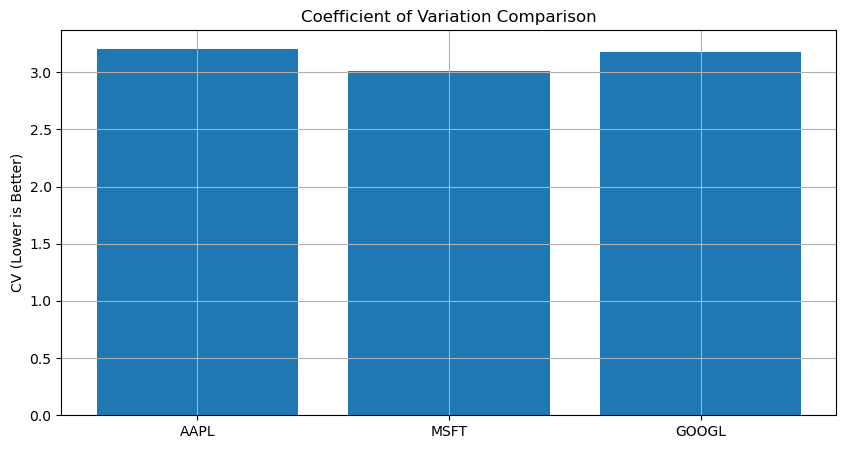


Adding XOM for comparison...
XOM CV: 4.0875 (vs Tech stocks: 3.1318)
Shows how energy sector provides different risk/return profile


In [8]:
cvs = {}
for ticker in portfolio_tickers:
    annual_std = portfolio[ticker]['log_return'].std() * np.sqrt(252)
    cvs[ticker] = annual_std / expected_returns[ticker]

    
print("\nCoefficient of Variation (Risk/Return Trade-off):")
for ticker, cv in cvs.items():
    print(f"{ticker}: {cv:.4f}")


print("\nInterpretation:")
print("Lower CV indicates better risk-adjusted returns")
print("Higher CV suggests more risk per unit of return")

# Visual comparison
plt.figure(figsize=(10,5))
plt.bar(cvs.keys(), cvs.values())
plt.title('Coefficient of Variation Comparison')
plt.ylabel('CV (Lower is Better)')
plt.grid(True)
plt.show()

# Add XOM
xom_data = get_tiingo_data("XOM", '2018-01-01', '2023-01-01')
xom_returns = safe_log_returns(xom_data)
xom_std = xom_returns.std() * np.sqrt(252)

# Calculate beta for XOM
xom_model = sm.OLS(xom_returns.dropna(), sm.add_constant(market_returns)).fit()
xom_beta = xom_model.params[1]
xom_er = risk_free_rate + xom_beta * (market_return - risk_free_rate)
xom_cv = xom_std / xom_er

print(f"XOM CV: {xom_cv:.4f} (vs Tech stocks: {np.mean(list(cvs.values())):.4f})")
print("Shows how energy sector provides different risk/return profile")

## 10.9 Covariance: Understanding Portfolio Diversification

Covariance is a method for calculating how returns move relative to one another in a portfolio. Lower covariance between assets indicates less risk.

In [10]:
# Create returns DataFrame
returns_df = pd.DataFrame({
    ticker: portfolio[ticker]['log_return'] 
    for ticker in portfolio_tickers
}).dropna()

# Annualized covariance
cov_matrix = returns_df.cov() * 252

print("\nAnnualized Covariance Matrix:")
print(cov_matrix)

# interpretation
print("\nKey Insights:")
print("1. Diagonal elements are variances (individual asset risks)")
print("2. Off-diagonal elements show how assets move together")
print("3. Lower covariance between assets indicates better diversification")

# Compare AAPL-GOOGL vs AAPL-MSFT 
aapl_googl = cov_matrix.loc['AAPL','GOOGL']
aapl_msft = cov_matrix.loc['AAPL','MSFT']
print(f"\nAAPL-GOOGL covariance: {aapl_googl:.6f}")
print(f"AAPL-MSFT covariance: {aapl_msft:.6f}")
print("Lower AAPL-GOOGL covariance suggests better diversification potential")

# Correlation matrix for comparison
corr_matrix = returns_df.corr()
print("\nCorrelation Matrix:")
print(corr_matrix)


# Explanation
print("\nCovariance vs Correlation:")
print("Covariance: Measures direction of linear relationship (magnitude matters)")
print("Correlation: Measures strength of linear relationship (normalized to [-1,1])")
print("For portfolio construction:")
print("- Covariance directly impacts portfolio variance calculations")
print("- Correlation helps identify diversification opportunities")



Annualized Covariance Matrix:
           AAPL      MSFT     GOOGL
AAPL   0.112258  0.080624  0.074138
MSFT   0.080624  0.096455  0.079170
GOOGL  0.074138  0.079170  0.098805

Key Insights:
1. Diagonal elements are variances (individual asset risks)
2. Off-diagonal elements show how assets move together
3. Lower covariance between assets indicates better diversification

AAPL-GOOGL covariance: 0.074138
AAPL-MSFT covariance: 0.080624
Lower AAPL-GOOGL covariance suggests better diversification potential

Correlation Matrix:
           AAPL      MSFT     GOOGL
AAPL   1.000000  0.774803  0.703958
MSFT   0.774803  1.000000  0.810976
GOOGL  0.703958  0.810976  1.000000

Covariance vs Correlation:
Covariance: Measures direction of linear relationship (magnitude matters)
Correlation: Measures strength of linear relationship (normalized to [-1,1])
For portfolio construction:
- Covariance directly impacts portfolio variance calculations
- Correlation helps identify diversification opportunities


##  10.10 Summary 

Portfolio analysis is essential for making informed investment decisions. By building a diversified portfolio, investors can reduce risk while optimizing returns. This chapter focuses on the key methodologies used to analyze portfolios and manage risk, such as calculating beta, expected returns using CAPM, and evaluating diversification with covariance matrices. We also explore multi-factor models, including the Fama-French three-factor model, to deepen our understanding of risk and return.